In [4]:
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz

In [5]:
website_df = pd.read_csv("website_data_with_classifications.csv")

In [6]:
website_df.head()

,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,5651.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,2082.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...",3799.0
3,NaN,NaN,"Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...",...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,5082.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,2369.0


In [7]:
website_df["category"].count()

4309

In [8]:
classification_col = website_df["category"]
classification_col = pd.Series([(str(int(x))[:2] if not pd.isnull(x) else "00") for x in classification_col])

In [17]:
def ngram_text(text):
    text = text.lower()
    return [text[i:i+3] for i in range(len(text)-3+1)]


In [67]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from rapidfuzz import fuzz, process
from functools import lru_cache

# session_year_map = {
#     2008: 110,
#     2012: 112,
#     2016: 114,
#     2020: 116
# }
session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
all_website_scores_by_category = {category: [] for category in classification_col.unique()}

sum_year_scores = []
num_websites = []
year_std_devs = []

categorized_normalized_year_scores = {category: [] for category in classification_col.unique()}
categorized_year_std_devs = {category: [] for category in classification_col.unique()}

SIMILARITY_THRESHOLD = 85

@lru_cache(maxsize=100000)
def cached_partial_ratio(phrase, token):
    return fuzz.partial_ratio(phrase, token)

def count_matches(ngrams, phrase):
    return sum([1 for ngram in ngrams if (cached_partial_ratio(phrase, ngram) >= SIMILARITY_THRESHOLD)])

phrase_count_by_year = {}

for year in session_year_map:
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv")
    clean_phrases = keywords_df["phrase_clean"]
    clean_phrases = clean_phrases.dropna()
    
    year_score = 0

    valid_columns = [col for col in website_df.columns if str(year) in col]
    subset = website_df[valid_columns[-1]] # select the last value within a given year

    subset = subset.fillna("")
    subset = subset.astype(str)
    
    subset_split = subset.apply(ngram_text)

    phrase_count = pd.DataFrame(0, index=website_df.index, columns=keywords_df["phrase_clean"])
    for phrase in tqdm(clean_phrases, total=len(clean_phrases)):
        # pattern = re.escape(phrase)
        # phrase_count[phrase] = subset.apply(lambda x: len(re.findall(pattern, x, re.IGNORECASE)))
        phrase_count[phrase] = subset_split.apply(lambda x: count_matches(x, phrase))
    phrase_count_by_year[year] = phrase_count

    y_n_denominator = sum(beta * beta for beta in keywords_df["beta"])

    website_scores = []
    website_scores_by_category = {category: [] for category in classification_col.unique()}

    websites_count = 0

    for website in tqdm(phrase_count.index):
        website_stats = phrase_count.loc[website]
        if not subset.loc[website]:
            continue
        phrase_count_sum = website_stats.sum()
        y_n_numerator = 0
        for phrase, beta, alpha in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
            y_n_numerator += beta * (((website_stats[phrase] / phrase_count_sum) if phrase_count_sum else 0) - alpha)
        year_score += y_n_numerator / y_n_denominator
        website_scores.append(y_n_numerator / y_n_denominator)
        website_category = classification_col[website]
        website_scores_by_category[website_category].append(y_n_numerator / y_n_denominator)
        websites_count += 1

    all_website_scores.append(website_scores)

    print("Websites count: ", websites_count, " Number of elements in website_scores: ", len(website_scores))

    sum_year_scores.append(np.sum(website_scores))
    num_websites.append(websites_count)
    year_std_devs.append(np.std(website_scores))

    for category in classification_col.unique():
        if len(website_scores_by_category[category]) == 0:
            print(f"Category {category} had no websites in year {year}")
        all_website_scores_by_category[category].append(website_scores_by_category[category])
        categorized_normalized_year_scores[category].append(np.mean(website_scores_by_category[category]))
        categorized_year_std_devs[category].append(np.std(website_scores_by_category[category]))

    print(f"Year {year} score: {year_score / websites_count}")

100%|██████████| 5189/5189 [00:02<00:00, 2261.63it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2304  Number of elements in website_scores:  2304
Category 43 had no websites in year 2007
Category 84 had no websites in year 2007
Category 86 had no websites in year 2007
Category 2 had no websites in year 2007
Category 47 had no websites in year 2007
Category 8 had no websites in year 2007
Year 2007 score: 0.5316737344824247


100%|██████████| 5189/5189 [00:02<00:00, 2201.96it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2436  Number of elements in website_scores:  2436
Category 43 had no websites in year 2008
Category 84 had no websites in year 2008
Category 86 had no websites in year 2008
Category 2 had no websites in year 2008
Category 8 had no websites in year 2008
Year 2008 score: 0.5318837561700388


100%|██████████| 5189/5189 [00:02<00:00, 2087.37it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2565  Number of elements in website_scores:  2565
Category 43 had no websites in year 2009
Category 84 had no websites in year 2009
Category 86 had no websites in year 2009
Category 2 had no websites in year 2009
Category 8 had no websites in year 2009
Year 2009 score: 0.5451911095841322


100%|██████████| 5189/5189 [00:02<00:00, 2033.28it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2717  Number of elements in website_scores:  2717
Category 43 had no websites in year 2010
Category 84 had no websites in year 2010
Category 86 had no websites in year 2010
Category 2 had no websites in year 2010
Category 8 had no websites in year 2010
Year 2010 score: 0.5457129167110213


100%|██████████| 5189/5189 [00:02<00:00, 1975.14it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  2964  Number of elements in website_scores:  2964
Category 43 had no websites in year 2011
Category 84 had no websites in year 2011
Category 2 had no websites in year 2011
Category 8 had no websites in year 2011
Year 2011 score: 0.37954617409219865


100%|██████████| 5189/5189 [00:02<00:00, 1894.53it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3096  Number of elements in website_scores:  3096
Category 43 had no websites in year 2012
Category 84 had no websites in year 2012
Category 2 had no websites in year 2012
Category 8 had no websites in year 2012
Year 2012 score: 0.3802069626166794


100%|██████████| 5189/5189 [00:02<00:00, 1822.81it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3318  Number of elements in website_scores:  3318
Category 43 had no websites in year 2013
Category 84 had no websites in year 2013
Category 2 had no websites in year 2013
Category 8 had no websites in year 2013
Year 2013 score: 0.2973722378640121


100%|██████████| 5189/5189 [00:02<00:00, 1770.54it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3528  Number of elements in website_scores:  3528
Category 43 had no websites in year 2014
Category 84 had no websites in year 2014
Category 2 had no websites in year 2014
Category 8 had no websites in year 2014
Year 2014 score: 0.2974084076721166


100%|██████████| 5189/5189 [00:03<00:00, 1703.84it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3686  Number of elements in website_scores:  3686
Category 84 had no websites in year 2015
Category 2 had no websites in year 2015
Year 2015 score: 0.3399996564453458


100%|██████████| 5189/5189 [00:03<00:00, 1682.89it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3820  Number of elements in website_scores:  3820
Category 84 had no websites in year 2016
Category 2 had no websites in year 2016
Year 2016 score: 0.3398380863990084


100%|██████████| 5189/5189 [00:03<00:00, 1599.44it/s]
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/research/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Websites count:  3942  Number of elements in website_scores:  3942
Category 84 had no websites in year 2017
Category 2 had no websites in year 2017
Year 2017 score: 0.49003880123693805


100%|██████████| 5189/5189 [00:03<00:00, 1590.42it/s]


Websites count:  4090  Number of elements in website_scores:  4090
Year 2018 score: 0.4898914646086411


100%|██████████| 5189/5189 [00:03<00:00, 1572.35it/s]


Websites count:  4163  Number of elements in website_scores:  4163
Year 2019 score: 0.4360114853219217


100%|██████████| 5189/5189 [00:03<00:00, 1551.19it/s]

Websites count:  4341  Number of elements in website_scores:  4341
Year 2020 score: 0.4359088647617643


In [73]:
import pickle
with open("phrase_count_by_year.pkl", "wb") as f:
    pickle.dump(phrase_count_by_year, f)


In [74]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])
print([np.std(scores) for scores in all_website_scores])

[0.5316737344824252, 0.5318837561700388, 0.5451911095841324, 0.5457129167110218, 0.3795461740921978, 0.38020696261668085, 0.2973722378640121, 0.2974084076721179, 0.33999965644534474, 0.33983808639900814, 0.49003880123693777, 0.4898914646086401, 0.43601148532192247, 0.4359088647617652]
[0.028705963682549206, 0.02721810267128841, 0.025203855376017704, 0.02216372353674251, 0.02076962906913416, 0.02443361958287052, 0.009816031999782211, 0.010712468722076578, 0.012260976283890548, 0.01249457601793159, 0.012034277320576242, 0.010695642970721037, 0.008904497808882413, 0.007850040804360914]


In [75]:
phrase_count_by_year

{2007: phrase_clean  tax increase  natural gas  bush administration  \
 0                        0            0                    0   
 1                        0            0                    0   
 2                        0            0                    0   
 3                       13           10                   24   
 4                       17            5                   13   
 ...                    ...          ...                  ...   
 5184                     0            0                    0   
 5185                     4            2                    5   
 5186                     0            0                    0   
 5187                     0            0                    0   
 5188                     0            0                    0   
 
 phrase_clean  african american  war iraq  raise tax  president bush  \
 0                            0         0          0               0   
 1                            0         0          0               0

In [76]:
phrase_count_by_year[2008].sum(axis=0).sort_values(ascending=False).head(50)

phrase_clean
international community     88895
working condition           86346
intervening action          84553
consumer protection         77777
production american         75753
military construction       73290
material resolution         70753
foreclosure prevention      69869
earning prestigious         69685
discretionary spending      66726
renovation replacement      66368
energy production           64949
consumer product            64169
abortion provider           63121
private contractor          60859
science transportation      60260
information publication     60031
excellent reputation        59603
higher education            58833
government spending         57757
sexual orientation          57743
production oil              56847
appropriation act           56595
intelligence community      56356
military commission         55933
mass destruction            55576
national laboratory         54948
order conduct               54258
need renovation             54106
i

In [77]:
print([np.sum(scores) for scores in all_website_scores])

[1224.9762842475075, 1295.6688300302146, 1398.4151960832996, 1482.7019947038464, 1124.9748600092744, 1177.120756261244, 986.6810852327922, 1049.256862267232, 1253.2387336575407, 1298.1814900442112, 1931.7329544760087, 2003.656090249338, 1815.1158133951633, 1892.2803819308228]


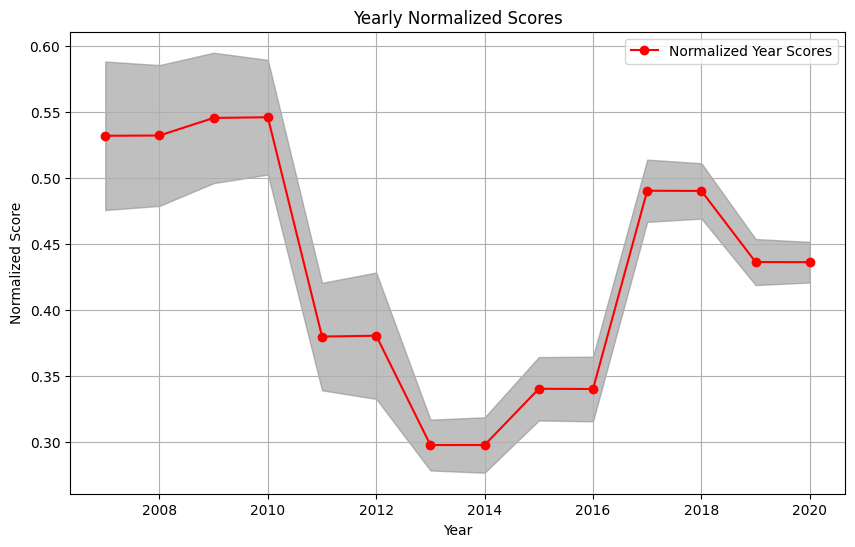

In [78]:
import matplotlib.pyplot as plt

years = list(session_year_map.keys())
normalized_year_scores = [np.mean(scores) for scores in all_website_scores]

plt.figure(figsize=(10, 6))
plt.plot(years, normalized_year_scores, marker='o', color='r', label='Normalized Year Scores')
plt.fill_between(years, 
                 [score - 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 [score + 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 color='gray', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Normalized Score')
plt.title('Yearly Normalized Scores')
plt.legend()
plt.grid(True)
plt.show()

Index(['1996-10', '1996-11', '1996-12', '1997-01', '1997-02', '1997-03',
       '1997-04', '1997-05', '1997-06', '1997-07',
       ...
       '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
       '2023-08', '2023-09', '2023-10', 'category'],
      dtype='object', length=326)


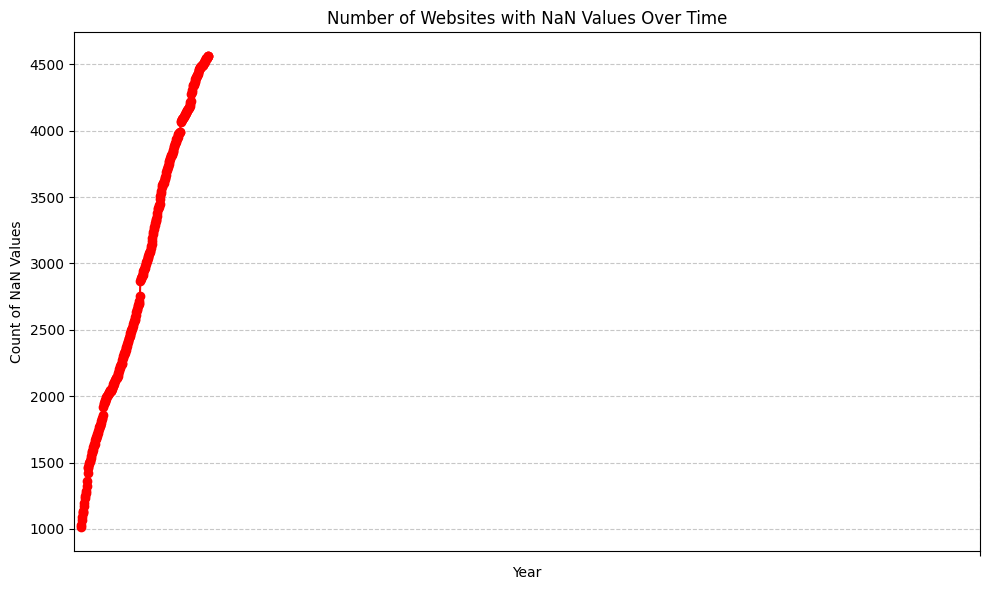

In [ ]:
nan_counts = []
print(website_df.columns)
year_columns = [col for col in website_df.columns if col.startswith("20") or col.startswith("19")]
for column in year_columns:
    nan_count = website_df[column].notna().sum()
    nan_counts.append(nan_count)

plt.figure(figsize=(10, 6))
plt.plot(year_columns, nan_counts, marker='o', linestyle='-', color='red')
plt.title('Number of Websites with NaN Values Over Time')
plt.xlabel('Year')
plt.ylabel('Count of NaN Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(years)
plt.tight_layout()
plt.show()